# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [1]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np
import numba as nb

from numba import njit
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

import rbush
from rbush.data import generate_data_array

In [2]:
print('datashader:',ds.__version__)
print('xarray:',xr.__version__)
print('bokeh:',bk.__version__)
print('pandas:',pd.__version__)
print('numpy:',np.__version__)
print('numba:',nb.__version__)

datashader: 0.6.4
xarray: 0.10.0
bokeh: 0.12.13
pandas: 0.20.3
numpy: 1.13.1
numba: 0.36.1


[RBush](https://github.com/parietal-io/py-rbush)
```
rbush.__version__ : '0.0.2+9.g355496a'
```

## Build tree

In [3]:
import rbush

In [4]:
from rbush.data import generate_data_array

def gaussian_grid(N, INCREMENT, SIZE):
    arrays = []

    # bottom-left
    arr = generate_data_array(N, SIZE)
    arr += SIZE
    arrays.append(arr)

    # top-right
    arr = generate_data_array(N, SIZE)
    arr += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-right
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT - SIZE
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT - SIZE
    arr[:,3] += SIZE
    arrays.append(arr)

    # top-left
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # top-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += SIZE
    arrays.append(arr)

    # left-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT // 2
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT // 2
    arrays.append(arr)

    data = np.concatenate(arrays, axis=0)
    return data

N = int(1e5)
EXTENT = 1000
SIZE = 100
data = gaussian_grid(N, EXTENT, SIZE)
print('Length: {:,}'.format(len(data)))
data

Length: 700,000


array([[ 115.36065436,  148.592959  ,  379.40584551,   48.22632305],
       [  72.82392556,  108.73989695,   54.148826  ,  145.69119607],
       [  75.73022578,   69.48476299,   92.9828358 ,   -2.60400523],
       ..., 
       [  57.27545009,  515.57829881,  154.76890255,  574.61118345],
       [ 100.4604737 ,  467.32492101,   71.414947  ,  528.38420063],
       [ -37.05103557,  513.82471633,    6.36754269,  416.51978641]])

In [5]:
t = rbush.RBush()
%time t.load(data)

CPU times: user 16.1 s, sys: 238 ms, total: 16.3 s
Wall time: 16.3 s


In [6]:
items = t.all()
bboxes = np.asarray([[i.xmin, i.ymin, i.xmax, i.ymax] for i in items])
bboxes

array([[ -138.05823754,  -251.5877081 ,  -203.96483682,  -308.33571392],
       [ -207.20289828,  -233.1179567 ,  -200.1228822 ,  -268.26347202],
       [ -151.65765316,  -197.73878828,   -62.75042111,  -250.08210199],
       ..., 
       [ 1153.4307819 ,  1193.27122485,  1020.6356973 ,  1300.7559771 ],
       [ 1155.90401127,  1197.72713895,  1148.58820314,  1031.11410647],
       [  -37.05103557,   513.82471633,     6.36754269,   416.51978641]])

In [7]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [8]:
ad = np.asarray([data.min(axis=0),data.max(axis=0),data.mean(axis=0)], int)
print(ad)

[[-337 -336 -601 -562]
 [1338 1349 1483 1602]
 [ 442  499  442  500]]


In [9]:
ab = np.asarray([bboxes.min(axis=0),bboxes.max(axis=0),bboxes.mean(axis=0)], int)
print(ab)

[[-337 -336 -601 -562]
 [1338 1349 1483 1602]
 [ 442  499  442  500]]


In [10]:
assert np.array_equal(ad,ab)

In [11]:
del data, ad, ab

## Visualizing Rbush' nodes with datashader

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- i.e, we want a heatmap of the items (space) distribution.

Each bin in the datashader (xarray) canvas will contain the number of items covering that area.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

### Plot: centroids

In [12]:
df = pd.DataFrame(bboxes, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)
df.describe()

xmin           ymin           xmax           ymax  \
count  700000.000000  700000.000000  700000.000000  700000.000000   
mean      442.803246     499.988214     442.789778     500.084456   
std       347.859669     383.665835     361.701840     396.604648   
min      -337.751790    -336.799035    -601.430451    -562.874135   
25%       121.023697     120.926146     128.742250     129.076331   
50%       432.223295     499.759279     412.672745     499.427742   
75%       786.491480     879.169139     758.399609     871.557522   
max      1338.379954    1349.189273    1483.644977    1602.072678   

                   x              y  
count  700000.000000  700000.000000  
mean      442.796512     500.036335  
std       351.308530     386.969827  
min      -392.443173    -393.234640  
25%       123.515901     123.322090  
50%       425.110506     499.543667  
75%       775.444224     876.974959  
max      1394.061939    1475.630975

In [13]:
# Data limits/range. We'll  use to define our canvas data space
#
BORDER = 100
x_lims = [int(df.xmin.min()) - BORDER, int(df.xmax.max()+1) + BORDER]
y_lims = [int(df.ymin.min()) - BORDER, int(df.ymax.max()+1) + BORDER]
print("Data limits:\n x: {}, y: {}\n".format(x_lims,y_lims))

Data limits:
 x: [-437, 1584], y: [-436, 1703]



<xarray.DataArray (y: 400, x: 800)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * y        (y) float64 -433.3 -428.0 -422.6 -417.3 -411.9 -406.6 -401.2 ...
  * x        (x) float64 -435.7 -433.2 -430.7 -428.2 -425.6 -423.1 -420.6 ...


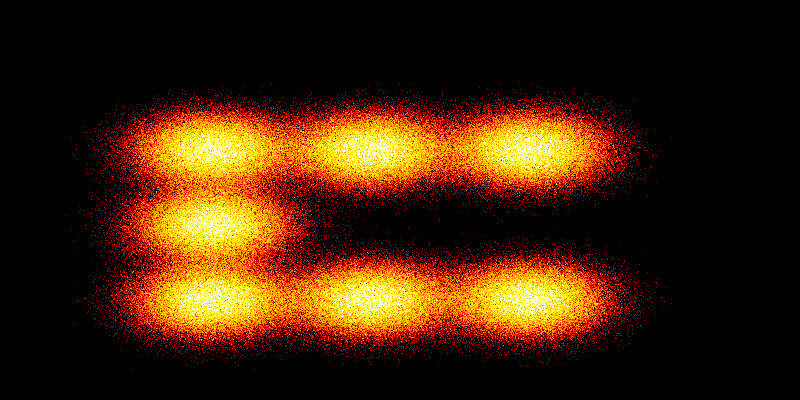

In [14]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

# We will represent centroids
glyph = ds.glyphs.Point('x', 'y')

# 400 x 800 pixels
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=x_lims, y_range=y_lims)

agg = canvas.points(df,'x','y', agg=reductions.count())
print(agg)

img = tf.shade(agg, cmap=Hot, how='eq_hist')
tf.set_background(img, 'black')

### Plot: bounding-boxes

To plot the items coverage we have to rasterize the bounding-boxes defined by our rbush items.
Size and quality of the image are dictated by the image's size and resolution; we have to choose one and other will adapt to fit data' limits.

We here, first, choose for fixing the resolution.

In [15]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
x_res = 1.0
y_res = 1.0
print("Canvas resolution(in 'data' units):\n x: {}, y: {}\n".format(x_res,y_res))

x_size = int((x_lims[1] - x_lims[0])/x_res)
y_size = int((y_lims[1] - y_lims[0])/y_res)
print("Canvas' axes size:\n x: {}, y: {}\n".format(x_size,y_size))

Canvas resolution(in 'data' units):
 x: 1.0, y: 1.0

Canvas' axes size:
 x: 2021, y: 2139



In [16]:
# Define the functions to transform coordinates 'data'<->'canvas'

def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f


def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(x_lims[0], x_res)
pos2pix_y = def_pos2pix(y_lims[0], y_res)

pix2pos_x = def_pix2pos(x_lims[0], x_res)
pix2pos_y = def_pix2pos(y_lims[0], y_res)

In [17]:
# Rasterize data
def pos2pix_data(a, data):
    for i in range(len(data)):
        row = data[i]
        xi = pos2pix_x(row[0])
        yi = pos2pix_y(row[1])
        xf = pos2pix_x(row[2])
        yf = pos2pix_y(row[3])
        a[yi:yf,xi:xf] += 1

# Array to represent the heatmap/histogram
a = np.zeros((y_size,x_size),dtype=int)

%time pos2pix_data(a, bboxes)

CPU times: user 8.71 s, sys: 30.5 ms, total: 8.74 s
Wall time: 8.76 s


In [18]:
# Let's build an xarray from 'a', which will effectively become our canvas (plot)

xaxis = np.arange(x_lims[0], x_lims[1], x_res)
yaxis = np.arange(y_lims[0], y_lims[1], y_res)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 2139, x: 2021)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) float64 -437.0 -436.0 -435.0 -434.0 -433.0 -432.0 -431.0 ...
  * y        (y) float64 -436.0 -435.0 -434.0 -433.0 -432.0 -431.0 -430.0 ...

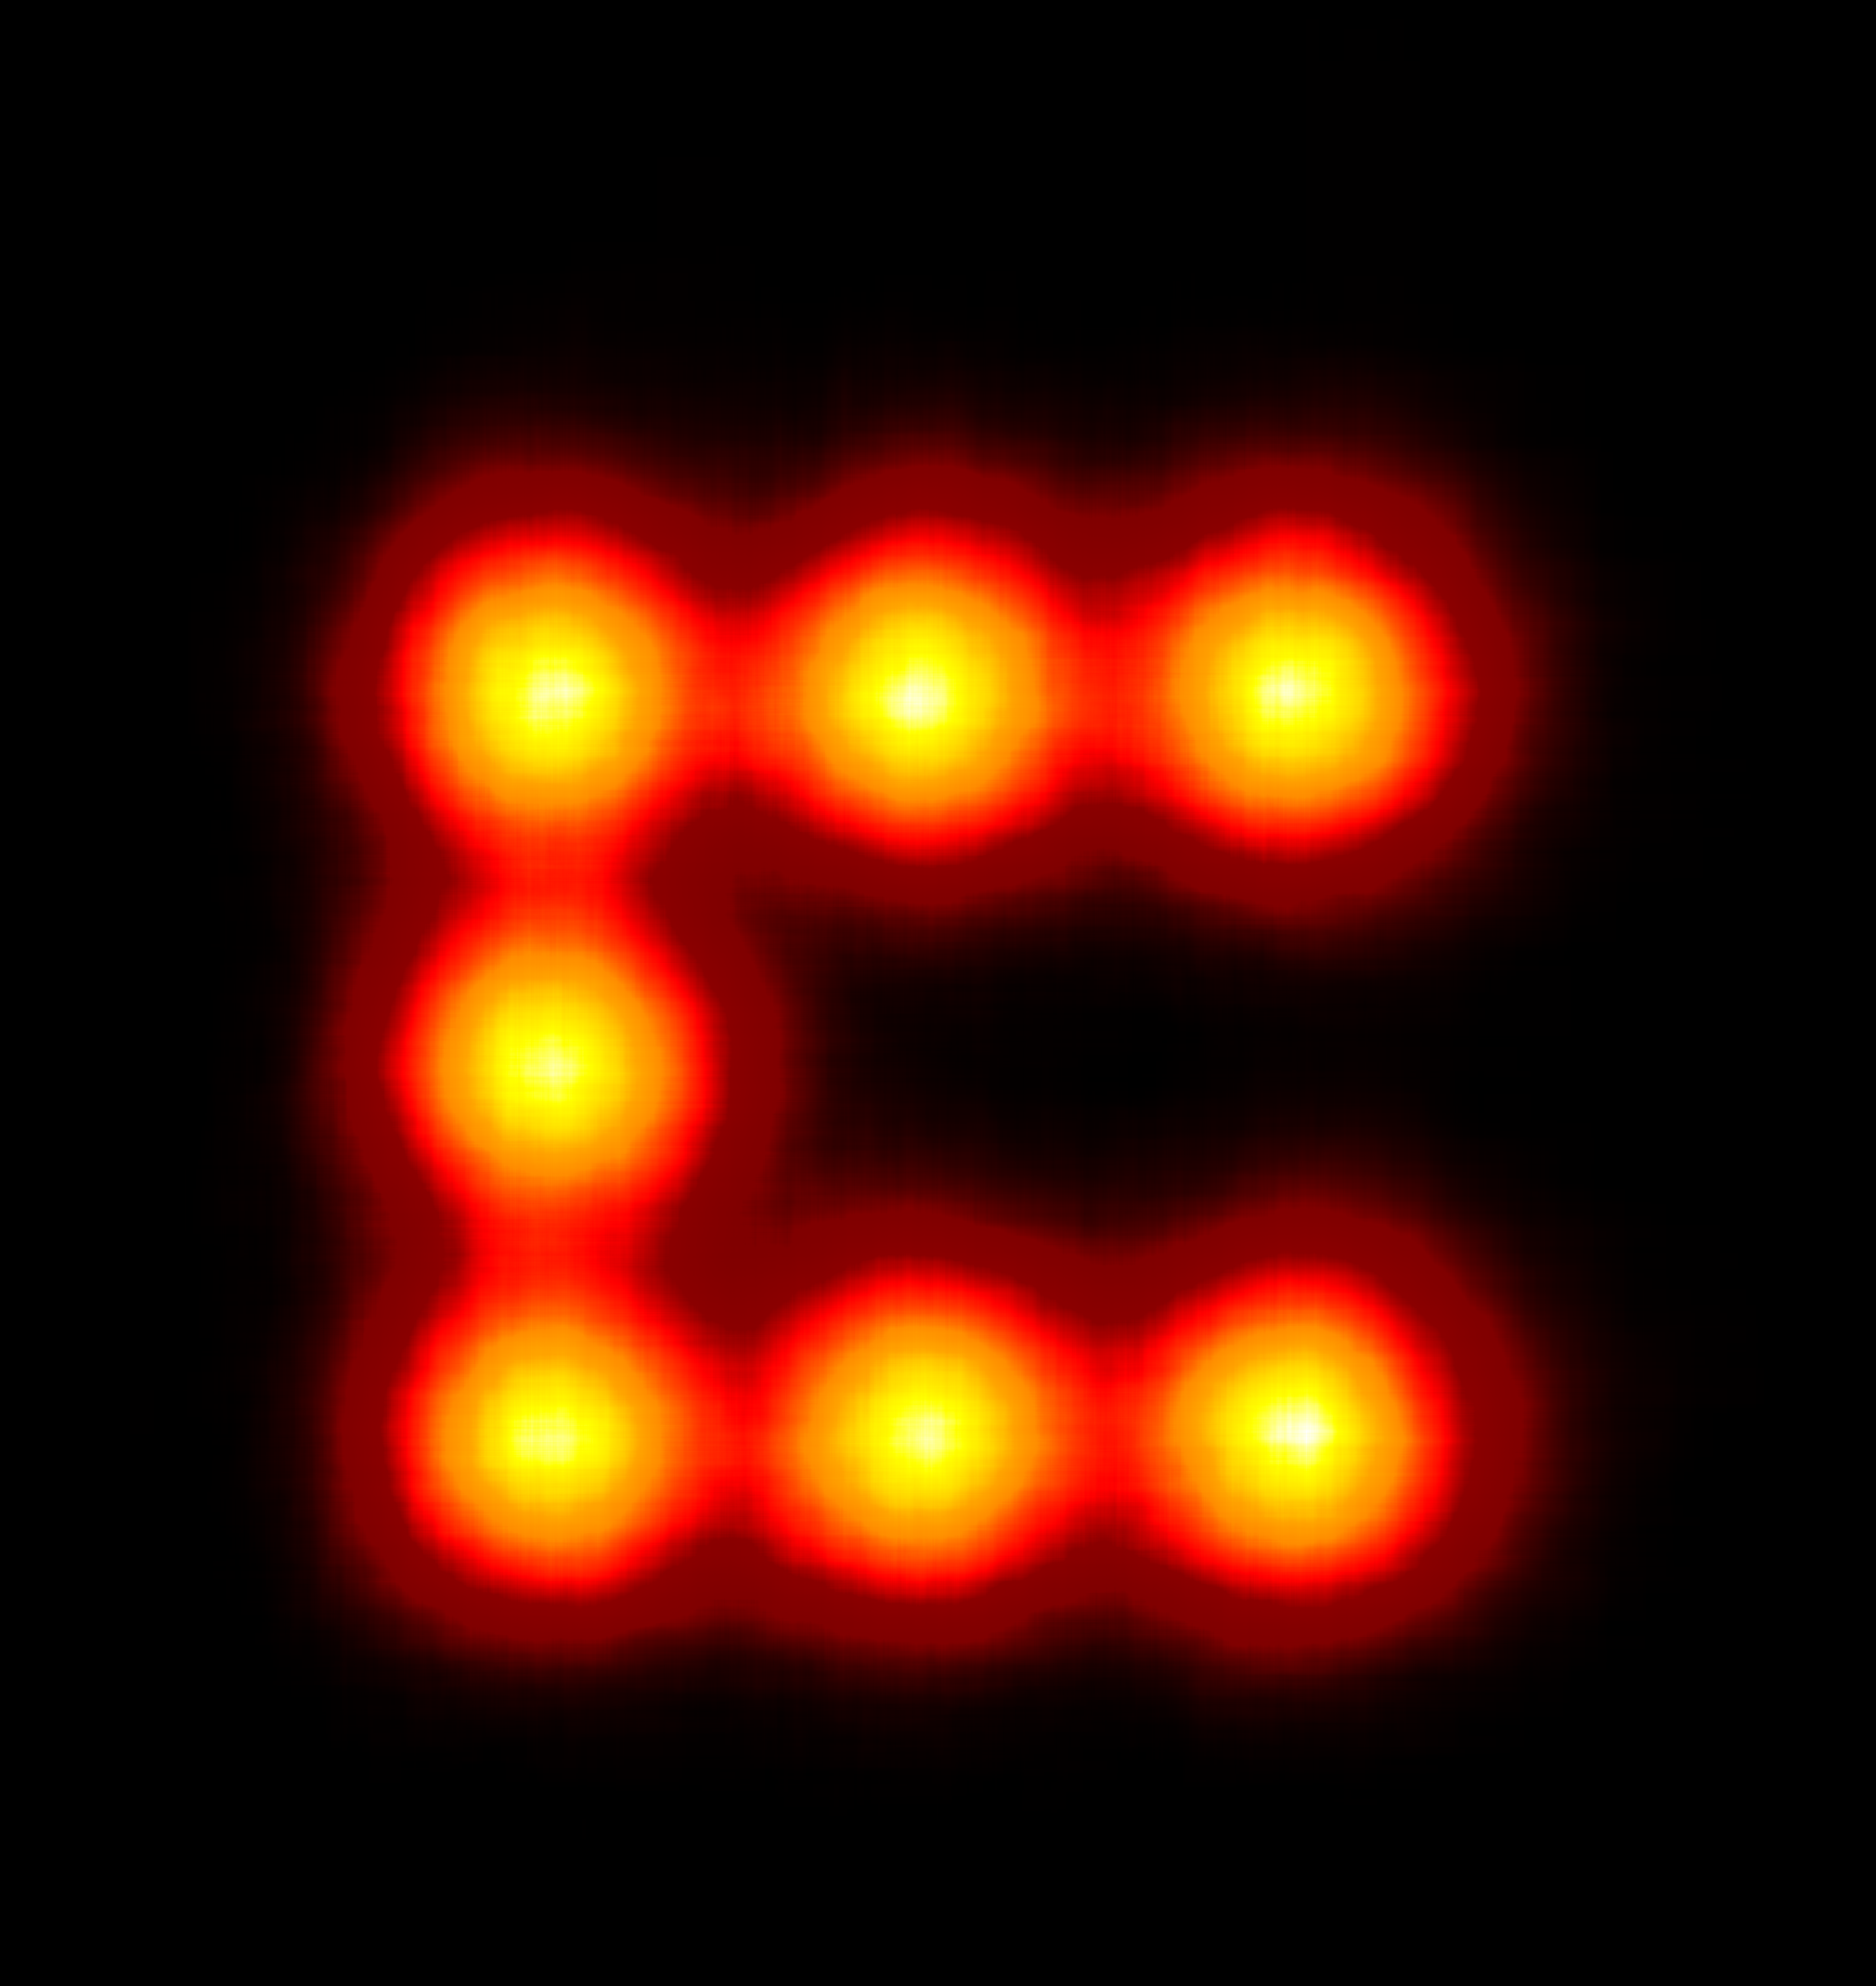

In [19]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

#### Define canvas size first, resolution follows

In [20]:
x_size = 400
y_size = 300
print("Canvas' axes size:\n x: {}, y: {}\n".format(x_size,y_size))

# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
x_res = (x_lims[1] - x_lims[0])/x_size
y_res = (y_lims[1] - y_lims[0])/y_size
print("Canvas resolution(in 'data' units):\n x: {}, y: {}\n".format(x_res,y_res))

Canvas' axes size:
 x: 400, y: 300

Canvas resolution(in 'data' units):
 x: 5.0525, y: 7.13



In [21]:
pos2pix_x = def_pos2pix(x_lims[0], x_res)
pos2pix_y = def_pos2pix(y_lims[0], y_res)

pix2pos_x = def_pix2pos(x_lims[0], x_res)
pix2pos_y = def_pix2pos(y_lims[0], y_res)

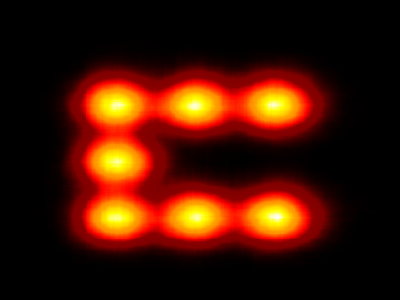

In [22]:
a = np.zeros((y_size,x_size),dtype=int)
pos2pix_data(a, bboxes)

xaxis = np.linspace(x_lims[0], x_lims[1], x_size)
yaxis = np.linspace(y_lims[0], y_lims[1], y_size)

axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

# Numba version

Now we're going to define the functions we used before using numba

In [23]:
xsize = 600
ysize = 400

xlims = x_lims
ylims = y_lims

xres = (xlims[1]-xlims[0])/xsize
yres = (ylims[1]-ylims[0])/ysize

In [24]:
from numba import guvectorize, vectorize
from numba import int64,float64,void

@vectorize(["int64(float64, float64, float64)"])
def pos2pix(pos, min_pos, res):
    return int64((pos - min_pos)/res)

@guvectorize(["void(float64[:,:], float64[:], float64[:], int64[:,:])"], "(n,c),(c),(c)->(n,c)")
def pos2pix_data(arr_data, posv, resv, pix):
    for i in range(arr_data.shape[0]):
        pix[i,:] = pos2pix(arr_data[i,:], posv, resv)

@njit('void(int64[:,:],int64[:,:])')
def rasterize(arr_pix, arr_canvas):
    for i in range(arr_pix.shape[0]):
        row = arr_pix[i]
        xi = row[0]
        yi = row[1]
        xf = row[2]
        yf = row[3]
        for y in range(yi,yf):
            for x in range(xi,xf):
                arr_canvas[y,x] += 1



a = np.zeros((ysize,xsize),dtype=int)

xmin = float(xlims[0])
ymin = float(ylims[0])
posv = np.array([xmin, ymin, xmin, ymin], dtype=float)
resv = np.array([xres, yres, xres, yres], dtype=float)

pix = np.zeros(bboxes.shape, dtype=int)

%time pos2pix_data(bboxes, posv, resv, pix)
%time rasterize(pix,a)

CPU times: user 95.8 ms, sys: 128 µs, total: 95.9 ms
Wall time: 96 ms
CPU times: user 81 ms, sys: 909 µs, total: 81.9 ms
Wall time: 81.7 ms


In [25]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 400, x: 600)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) float64 -437.0 -433.6 -430.3 -426.9 -423.5 -420.2 -416.8 ...
  * y        (y) float64 -436.0 -430.7 -425.3 -420.0 -414.6 -409.3 -403.9 ...

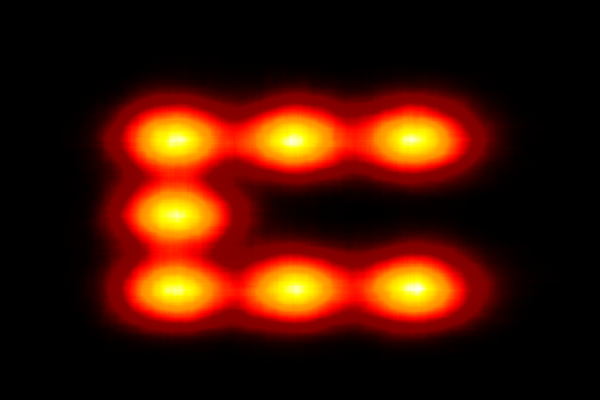

In [26]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

## Interactive view

In [27]:
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

x_range = xlims
y_range = ylims

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,box_zoom,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
# options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

In [28]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    # query rbush for only rectangles inside of ranges
    
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # I'm using here the previous/all-items df just to prototype (i.e, copy!) from the example(s)
    agg = cvs.points(df, 'x', 'y', agg=reductions.count())
    
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image)


In [29]:
print(x_range,y_range)

[-437, 1584] [-436, 1703]


In [30]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def query_tree(x_range, y_range):    
    bboxes = t.search(x_range[0], y_range[0], x_range[1], y_range[1])
    
    df = pd.DataFrame(bboxes, columns=['xmin','ymin','xmax','ymax'])
    df['x'] = df[['xmin','xmax']].mean(axis=1)
    df['y'] = df[['ymin','ymax']].mean(axis=1)
    return df

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    
    # query rbush for only rectangles inside of ranges
    df = query_tree(x_range, y_range)
    
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    agg = cvs.points(df, 'x', 'y', agg=reductions.count())
    
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image)


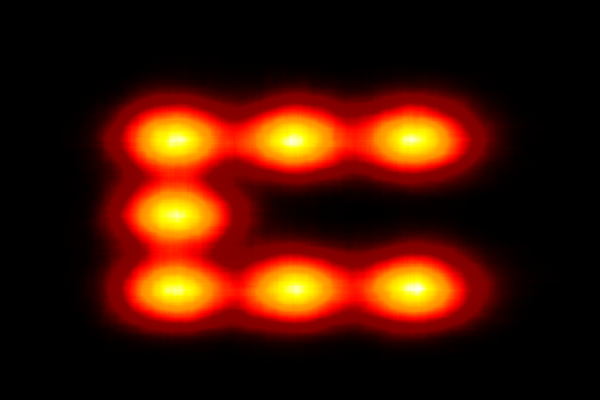

In [31]:
def set_canvas(x_range, y_range, rbush_tree):
#     print(x_range, y_range)
    
    xres = (x_range[1] - x_range[0])/xsize
    yres = (y_range[1] - y_range[0])/ysize
    
    a = np.zeros((ysize,xsize),dtype=int)

    xmin = float(x_range[0])
    ymin = float(y_range[0])
    posv = np.array([xmin, ymin, xmin, ymin], dtype=float)
    resv = np.array([xres, yres, xres, yres], dtype=float)

    bboxes = rbush_tree.search(x_range[0], y_range[0], x_range[1], y_range[1])
    pix = np.zeros(bboxes.shape, dtype=int)

    pos2pix_data(bboxes, posv, resv, pix)

    rasterize(pix,a)

    xaxis = np.arange(x_range[0], x_range[1], xres)
    yaxis = np.arange(y_range[0], y_range[1], yres)
    axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
    return axx


xax = set_canvas(x_range, y_range, t)

img = tf.shade(xax, cmap=Hot, how='linear')
tf.set_background(img, 'black')


In [32]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    # query rbush for only rectangles inside of ranges
    xax = set_canvas(x_range, y_range, t)

    img = tf.shade(xax, cmap=Hot, how='linear')

    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image, timeout=20)


**When we zoom-in we see there is a bug: the image presents a mirror effect.** After reviewing the code -- and the error not been found -- I am in doubt about how to debug that. May be an effect of the slowness of Rbush' query?: datashader would get confused when timeout is exceeded. (although a timeout sufficiently large doesn't solve the issue)